In [1]:
#https://mikaem.github.io/shenfun-demos/content/poisson.html#shen1
import numpy as np 
import matplotlib.pyplot as plt
from pypde.dmsuite import *
from scipy.fftpack import dctn
from pypde.bases.chebyshev import *
from pypde.utils.inner import *


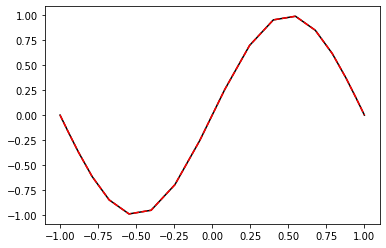

In [5]:
N = 20
CD = ChebDirichlet(N)
x = CD.x

def fun(x):
    return np.sin(2*np.pi/2*x)

c = CD.project_via_mass(fun(x))
y = CD.eval(c)

plt.plot(x,fun(x),"k")

plt.plot(x,y,"r--")
plt.show()

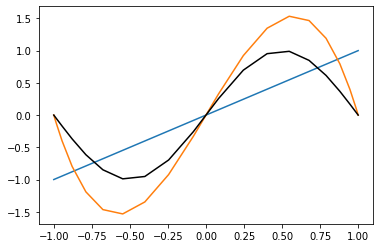

In [6]:

from shenfun import *
N = 20
D0 = FunctionSpace(N, 'C', basis='Orthogonal'   ,quad="GL")
DS = FunctionSpace(N, 'C', basis='ShenDirichlet',quad="GL")
x = D0.mesh()
plt.plot(x,D0.evaluate_basis(x,i=1))
plt.plot(x,DS.evaluate_basis(x,i=1))
plt.plot(x,fun(x),"k")
plt.show()


c = project(fun(x), D0)